## 第1步：引入必要的包

In [1]:
import sys
sys.path.insert(0, "diffusers/src")
import torch
from diffusers.utils import load_image
from diffusers.pipelines.flux.pipeline_flux_controlnet_inpaint import FluxControlNetInpaintPipeline
from diffusers.models.controlnet_flux import FluxControlNetModel
from diffusers import FluxMultiControlNetModel
from diffusers.utils import load_image, check_min_version
from PIL import Image
import cv2
import numpy as np
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import requests
import matplotlib.pyplot as plt
import torch.nn as nn
from controlnet_aux import HEDdetector, MidasDetector, MLSDdetector, OpenposeDetector, PidiNetDetector, NormalBaeDetector, LineartDetector, LineartAnimeDetector, CannyDetector, ContentShuffleDetector, ZoeDetector, MediapipeFaceDetector, SamDetector, LeresDetector, DWposeDetector
import os
from pathlib import Path
from inpaint import get_mask

/root/miniconda3/envs/diffusers/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


## 第2步：加载模型

In [2]:
# 1. 加载canny检测器
    canny = CannyDetector()

# 2. 加载衣服分割模型
cloth_processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
cloth_model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

# 加载flux模型和 controlnet 

base_model = 'black-forest-labs/FLUX.1-dev'
controlnet_model = 'YishaoAI/flux-dev-controlnet-canny-kid-clothes'

controlnet = FluxControlNetModel.from_pretrained(controlnet_model, torch_dtype=torch.bfloat16)


pipe = FluxControlNetInpaintPipeline.from_pretrained(base_model, controlnet=controlnet, torch_dtype=torch.bfloat16)
pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power


/root/miniconda3/envs/diffusers/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


## 第3步：加载图片，提取 mask 和边缘

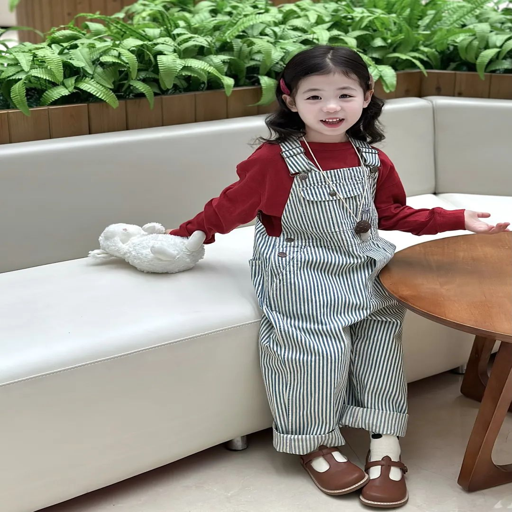

In [3]:
# image = load_image("https://img.61kids.cn/collect/202409031648061716.png")

image = load_image("https://img.61kids.cn/collect/202409031648214310.png")

mask = get_mask(image, cloth_processor, cloth_model)
mask = Image.fromarray(cv2.merge([mask, mask, mask]))
canny_image = canny(image)
image.resize((512, 512))


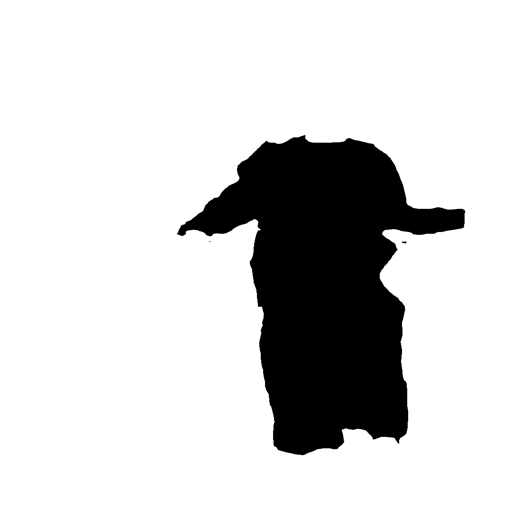

In [4]:
mask.resize((512, 512))

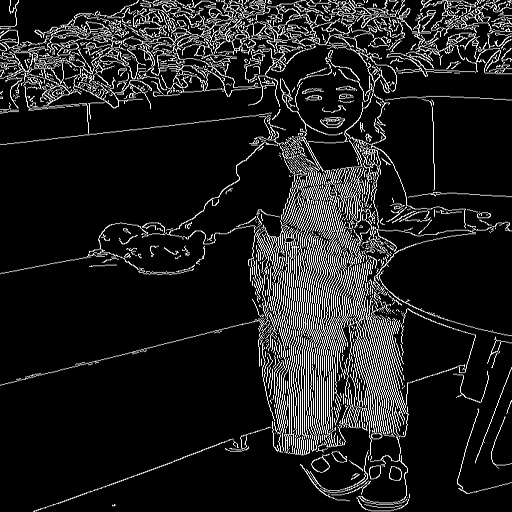

In [5]:
canny_image.resize((512, 512))

## 第4步：inpaint 生成

In [13]:
import random
images = []
for seed in range(100, 103):
    scale = 0.8
    prompt = "children's clothing model"            
    prompt = prompt + ", indoor" if random.uniform(0,1)<0.5 else prompt + ", outdoor"
    generator = torch.Generator(device="cpu").manual_seed(seed)
    image_res = pipe(
        prompt,
        image=image,
        control_image=canny_image,
        controlnet_conditioning_scale=0.65,
        mask_image=mask,
        strength=0.95,
        num_inference_steps=50,
        guidance_scale=5,
        generator=generator,
        joint_attention_kwargs={"scale": scale},    
    ).images[0]
    images.append(image_res.resize((512, 512)))

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

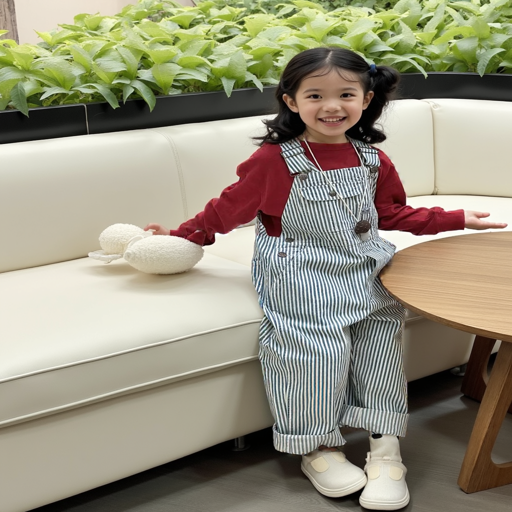

In [14]:
images[0]

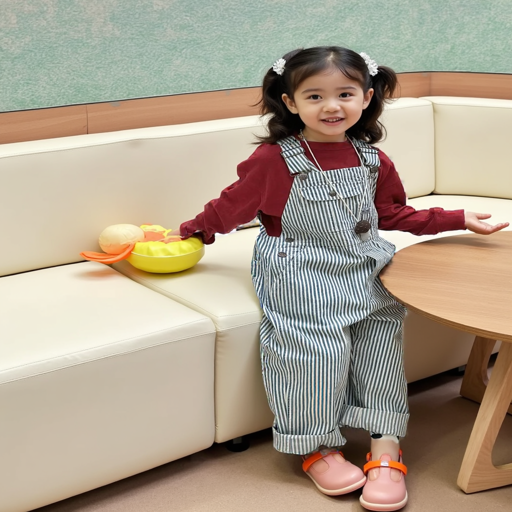

In [15]:
images[1]

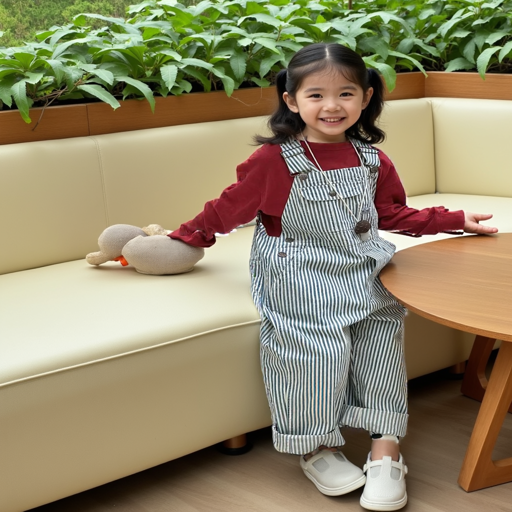

In [16]:
images[2]